This notebook assesses the performance of the proposed method for recovering the weights in the analysis problem of GW-barycenters

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing
import scipy as sp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import time
import kagglehub
import ot

In [15]:
# Create an MDS instance
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

# Download the dataset from Kaggle and save the path
path = kagglehub.dataset_download("cristiangarcia/pointcloudmnist2d")

# Load the test dataset from the downloaded files
df = pd.read_csv(path + "/test.csv")

# Extract numerical data (point cloud coordinates) from the dataset, excluding the first column (which contains labels)
Data = df[df.columns[1:]].to_numpy()

# Extract labels (digits) from the first column
label = df[df.columns[0]].to_numpy()

# Reshape data into an array of the form (sample_index, point_index, [point_coordinate[0],point_coordinate[1],point_mass])
Data = Data.reshape(Data.shape[0], -1, 3)

# Create a list of indices for each digit (0-9), grouping their occurrences in the dataset
digit_indices = [np.where(label == digit)[0].tolist() for digit in range(10)]

In [16]:
def get_lambdas(matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the barycentric weights (lambda_1,...,lambda_S), where S is the number of templates.
    Computes a candidate for a barycenter matrix associated with the barycenter weights using one iteration of the forward GW-barycenter problem.
      See for example remark 2.9 or equation 11.
    
    Input:
      matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
      measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
      matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze.
      measure_input: Probability vector of length M.

    Output:
      lambdas: Vector of weights, one for each template (S elements). These are not necessarily non-negative.
      matrix_output: Synthesized dissimilarity matrix.
    '''
    
    S = len(matrix_temp_list)  # Number of template matrices

    pi_list = []  # List to store Gromov-Wasserstein transport plans
    F_list = []   # List to store transformed matrices

    # Compute Q matrix (inverse of the outer product of measure_input)
    Q = (measure_input.reshape(-1, 1) @ measure_input.reshape(1, -1))
    Q = 1. / Q  # Element-wise inverse

    # Compute Gromov-Wasserstein transport maps and one iteration of the forward GW-barycenter problem
    for s in range(S):
        # Compute optimal transport plan (pi_s) using Gromov-Wasserstein transport
        pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input, 
                                            measure_temp_list[s], measure_input)
        pi_list.append(pi_s)

        # Compute F_s transformation using Q and pi_s
        F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)  # Element-wise multiplication
        F_list.append(F_s)

    # Set up and solve the linear problem (K@lambdas = b) for the vector of weights lambdas
    # Construct K matrix and b vector for least squares problem
    K = np.zeros((S, S))
    b = np.zeros(S)

    for i in range(S):
        b[i] = np.trace(matrix_input @ F_list[i])  # Compute b_i
        for j in range(S):
            K[i, j] = np.trace(F_list[i] @ F_list[j])  # Compute K_ij

    # Augment K with an additional row and column for sum-to-one constraint
    K_aug = np.hstack([K, -0.5 * np.ones(S).reshape(-1, 1)])  
    last_row = np.ones(K_aug.shape[1]).reshape(1, -1)  
    last_row[0, -1] = 0  
    K_aug = np.vstack([K_aug, last_row])  

    # Augment b with the constraint that lambdas sum to 1
    b_aug = np.hstack([b, [1]])

    # Solve for lambdas using the linear system K_aug * lambdas = b_aug
    lambdas = np.linalg.solve(K_aug, b_aug)

    # Extract lambda values (excluding the last auxiliary value corresponding to the lagrange multiplier of the sum-to-one constraint)
    lambdas = lambdas[:-1]

    # Compute the synthesized output matrix
    matrix_output = np.zeros_like(matrix_input)

    for s in range(S):
        matrix_output += lambdas[s] * F_list[s]  # Weighted sum of transformed matrices
        matrix_input = matrix_output  # Update matrix_input (although this might be redundant)

    return matrix_output, lambdas

In [17]:
def occlusion(X,a):
  # Define occlusion box
  box_center = np.array([0.5, 0.5])  # Center of the occlusion
  box_size = np.array([0.3, 0.3])  # Width and height of the occlusion box
  box_min = box_center - box_size / 2
  box_max = box_center + box_size / 2

  # Mask points inside the box
  mask = (X[:, 0] < box_min[0]) | (X[:, 0] > box_max[0]) | (X[:, 1] < box_min[1]) | (X[:, 1] > box_max[1])

  # Apply mask to X and a
  X_occluded = X[mask]  # Keep only points outside the occlusion box
  a_occluded = a[mask]  # Remove mass inside the box

  # Renormalize `a` so it sums to 1
  a_occluded /= a_occluded.sum()

  return X_occluded, a_occluded

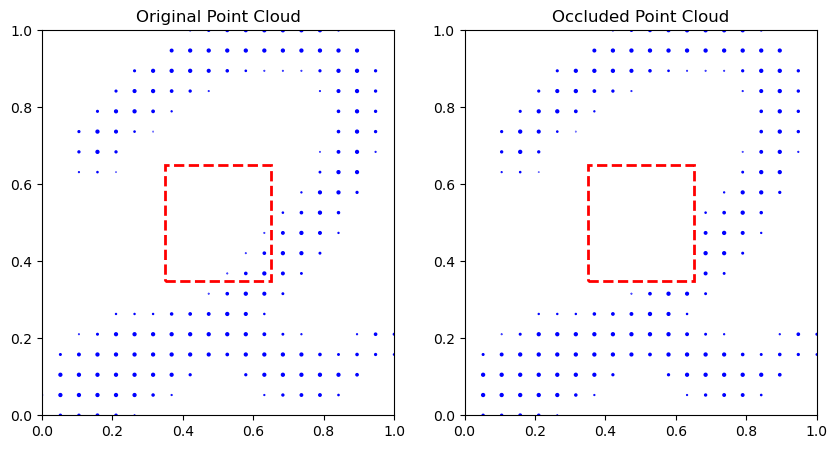

In [18]:
# Testing the occlusion in one sample of the data set

# Select a random sample
u = np.random.randint(0, 100)
a = Data[u, :, 2]  # Original mass values
X = Data[u, a != -1, :2]  # Extract valid points

# Normalize X
X = X - X.mean(0)[np.newaxis, :]
X -= X.min(axis=0)
X /= X.max(axis=0)

# Filter `a` (only keep valid entries)
a = a[a != -1]
a = a / float(a.sum())  # Normalize to sum to 1

# Define occlusion box
box_center = np.array([0.5, 0.5])  # Center of the occlusion
box_size = np.array([0.3, 0.3])  # Width and height of the occlusion box
box_min = box_center - box_size / 2
box_max = box_center + box_size / 2

# Mask points inside the box
mask = (X[:, 0] < box_min[0]) | (X[:, 0] > box_max[0]) | (X[:, 1] < box_min[1]) | (X[:, 1] > box_max[1])

# Apply mask to X and a
X_occluded, a_occluded = occlusion(X,a)


# Plot before and after occlusion
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X[:, 0], X[:, 1], s=a * 500, color='blue')
ax[0].set_title("Original Point Cloud")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[1].scatter(X_occluded[:, 0], X_occluded[:, 1], s=a_occluded * 500, color='blue')
ax[1].set_title("Occluded Point Cloud")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

# Draw occlusion box
for a in ax:
    a.add_patch(plt.Rectangle(box_min, box_size[0], box_size[1], edgecolor='red', facecolor='none', linestyle='--', lw=2))

plt.show()

Get templates and is perturbations (occlusion.)

In [19]:
# Get templates and is perturbations (occlusion.)
# Templates are of the form (matrix, measure)

digit = 3   # Pick a digit from 0 to 9

n_temp = 3   # Number of templates

ind_temp_list = []   #list of template indices from dataset
measure_temp_list = []   #list of template measures
matrix_temp_list = []   #list of template dissimilarity matrices
measure_occ_list = []   #list of template measures occluded
matrix_occ_list = []   #list of template dissimilarity matrices occluded


for s in range(n_temp):
    # Select a random index corresponding to the chosen digit
    ind = digit_indices[digit][np.random.randint(len(digit_indices[digit]))]
    ind_temp_list.append(ind)

    # Extract the probability measure from the third column of Data (p_s)
    p_s = Data[ind, :, 2]

    # Find valid indices where p_s is not -1 (avoiding missing or padded values)
    valid_indices = np.where(p_s != -1)[0]
    
    # Filter out invalid entries from p_s
    p_s = p_s[valid_indices]

    # Normalize p_s to make it a valid probability distribution
    p_s = p_s / float(p_s.sum())
    measure_temp_list.append(p_s)

    # Extract spatial coordinates (first two columns of Data) for valid points
    C_s = Data[ind, valid_indices, :2]

    # Center the points by subtracting the mean
    C_s = C_s - C_s.mean(0)[np.newaxis, :]

    # Normalize coordinates to fit within the unit square [0,1]²
    C_s -= C_s.min(axis=0)  # Shift to start at 0
    C_s /= C_s.max(axis=0)  # Scale to fit within [0,1]

    # Compute the pairwise Euclidean distance matrix for C_s
    dist_matrix_s = sp.spatial.distance.cdist(C_s, C_s)
    matrix_temp_list.append(dist_matrix_s)

    # Apply occlusion to the spatial coordinates and probability measure
    C_occluded, p_occluded = occlusion(C_s, p_s)
    measure_occ_list.append(p_occluded)

    # Compute the distance matrix for the occluded points
    dist_matrix_occ = sp.spatial.distance.cdist(C_occluded, C_occluded)
    matrix_occ_list.append(dist_matrix_occ)

In [20]:
# Generate random vector of weights 
lambdas_list = np.random.rand(n_temp)
lambdas_list = lambdas_list/lambdas_list.sum()

In [33]:
# Synthesize a Barycenter using POT
M = 100 # Dimension of output barycentric matrix is MxM.
M = len(C_s)

#b = np.ones(M) / M   # Uniform target probability vector
b = np.random.rand(M)
b = b/b.sum()   # Random target probability vector

B =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas_list)  # Synthesize barycenter matrix
B = (B + B.T) / 2   # enforce symmetry

# Center and fit points to be in the [0,1]x[0,1] square for later visualization
points_B = mds.fit_transform(B,init = C_s)
points_B = points_B-points_B.mean(0)[np.newaxis,:]
points_B -= points_B.min(axis=0)
points_B /= points_B.max(axis=0)

/home/ivanmedri/anaconda3/envs/gromov_barycenters/lib/python3.12/site-packages/sklearn/manifold/_mds.py:343: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


Synthesize a perturbed Barycenter using POT.

In [47]:
## Occluding the barycenter and compute distance matrix
B1, b1 = occlusion(points_B,b)
dist_matrix_occ = sp.spatial.distance.cdist(B1, B1)

In [48]:
_, lambdas = get_lambdas(matrix_occ_list, measure_occ_list,dist_matrix_occ, b1)

B_recon =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas)
B_recon = (B_recon + B_recon.T) / 2   # sym

print('Lambdas Error = ', np.linalg.norm(lambdas_list - lambdas, 1))


## Compare Original target vs reconstruction
gromov_distance = ot.gromov.gromov_wasserstein(B,B_recon,b,b, log=True)[1]
gw_dist = gromov_distance['gw_dist']
print(f'GW(Target,Reconstructed Target): {gw_dist}')

Lambdas Error =  0.08324417647547269
GW(Target,Reconstructed Target): 0.0012189122734207742


Visualize by using MDS embedding

In [49]:
## Fit and transform the distance matrix
points_B_recon = mds.fit_transform(B_recon,  init = points_B)
points_B_recon = points_B_recon-points_B_recon.mean(0)[np.newaxis,:]
points_B_recon -= points_B_recon.min(axis=0)
points_B_recon /= points_B_recon.max(axis=0)

/home/ivanmedri/anaconda3/envs/gromov_barycenters/lib/python3.12/site-packages/sklearn/manifold/_mds.py:343: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


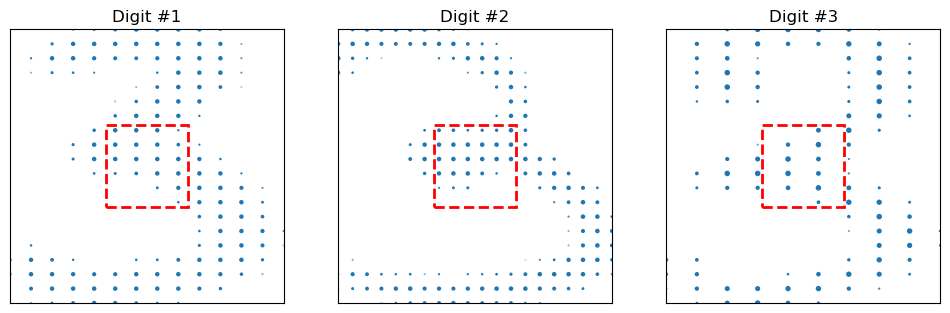

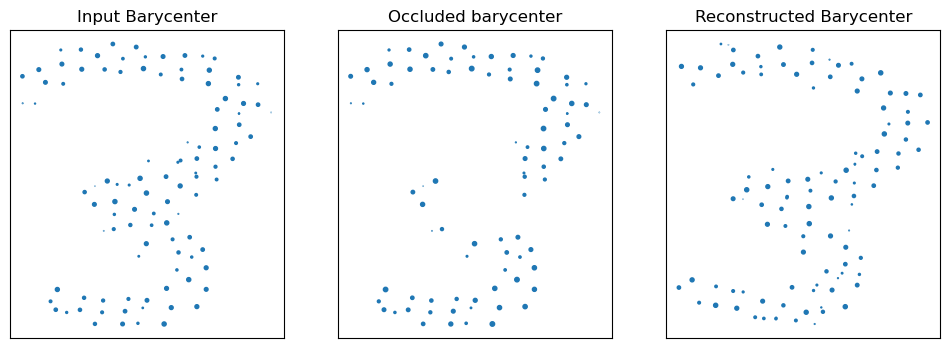

In [51]:
## Plot templates
fig, axes = plt.subplots(1, n_temp, figsize=(12, 6))
axes = axes.flatten()

for i, ind in enumerate(ind_temp_list):
    a = Data[ind,:,2]
    X = Data[ind,a!=-1,:2]
    X = X-X.mean(0)[np.newaxis,:]
    X -= X.min(axis=0)
    X /= X.max(axis=0)
    a = a[a!=-1]
    a = a/float(a.sum())
    axes[i].scatter(X[:, 0], X[:, 1], s=a*500)
    axes[i].set_title(f'Digit #{i+1}')
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].set_xticks([])  # Remove x-axis ticks
    axes[i].set_yticks([])  # Remove y-axis ticks
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    #axes[i].axis('off')

# Draw occlusion box
for a in axes:
    a.add_patch(plt.Rectangle(box_min, box_size[0], box_size[1], edgecolor='red', facecolor='none', linestyle='--', lw=2))

plt.show()


## Plot Barycenter and check if it is a fix point of the iteration
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].scatter(points_B[:, 0], points_B[:, 1], s=b*500)
axes[0].set_title('Input Barycenter')
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks

axes[1].scatter(B1[:, 0], B1[:, 1], s=b1*500)
axes[1].set_title('Occluded barycenter')
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks

axes[2].scatter(-points_B_recon[:, 0], -points_B_recon[:, 1], s=b*500)
axes[2].set_title('Reconstructed Barycenter')
axes[2].set_xticks([])  # Remove x-axis ticks
axes[2].set_yticks([])  # Remove y-axis ticks

plt.show()



In [49]:
# Option 1

points_B1 = mds.fit_transform(B1)
points_B1 = points_B1-points_B1.mean(0)[np.newaxis,:]
points_B1 -= points_B1.min(axis=0)
points_B1 /= points_B1.max(axis=0)

points_B_recon = mds.fit_transform(B_recon1)
points_B_recon = points_B_recon-points_B_recon.mean(0)[np.newaxis,:]
points_B_recon -= points_B_recon.min(axis=0)
points_B_recon /= points_B_recon.max(axis=0)

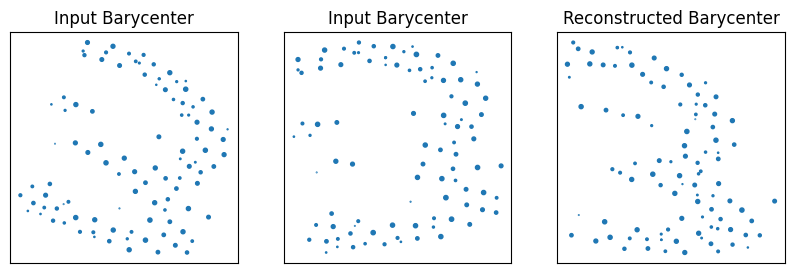

In [64]:
## Plot Barycenter and check if it is a fix point of the iteration
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].scatter(-points_B[:, 0], points_B[:, 1], s=b*500)
axes[0].set_title('Input Barycenter')
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks


axes[1].scatter(points_B1[:, 0], -points_B1[:, 1], s=b1*500)
axes[1].set_title('Input Barycenter')
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks

axes[2].scatter(-points_B_recon[:, 0], points_B_recon[:, 1], s=b*500)
axes[2].set_title('Reconstructed Barycenter')
axes[2].set_xticks([])  # Remove x-axis ticks
axes[2].set_yticks([])  # Remove y-axis ticks

# Draw occlusion box
# for a in axes:
#     a.add_patch(plt.Rectangle(box_min, box_size[0], box_size[1], edgecolor='red', facecolor='none', linestyle='--', lw=2))

plt.show()



